In [1]:
from keras.models import load_model
from keras.layers import Activation, Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from keras.applications.vgg19 import VGG19
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def Build_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Transfer VGG Model 
    # -------------------------------------------------------------------------
    # load VGG model
    vgg = VGG19(include_top = True, input_shape = (224, 224, 3))
    
    # mark loaded layers as trainable
    for layer in vgg.layers:
	    layer.trainable = False      
	       
    #  Flatten and Fully Connected Layer
    Flat_layer = Flatten()(vgg.layers[11].output)

    FC_layer = Dense(100)(Flat_layer)    
       
    Act_layer = Activation('relu')(FC_layer)
    
    #  Softmax Classifier
    Class_layer = Dense(1)(Act_layer)
    
    Softmax_layer = Activation('softmax')(Class_layer)
        
	# define new model    
    model = Model(inputs = vgg.inputs, outputs = Softmax_layer)
            
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [4]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    # create data generators    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale = 1.0/255.0,
                                     featurewise_center = True,
                                     featurewise_std_normalization = True,
                                     rotation_range = 10,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     zoom_range = 0.2,                                     
                                     brightness_range = [0.2, 1.0],
                                     )
    valid_datagen = ImageDataGenerator(
                                     rescale = 1.0 / 255.0,)
    
   
   
    # prepare iterators
    train_it = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train',class_mode = 'binary', batch_size = 16, target_size = (224, 224))
    valid_it = valid_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val',class_mode = 'binary', batch_size = 8, target_size = (224, 224))


    history = model.fit(
    train_it,
    steps_per_epoch = 50,
    epochs = 20,
    validation_data = valid_it)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')

In [5]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size = 32
    test_datagen = ImageDataGenerator(
                                     rescale = 1.0 / 255.0,)
    
    test_it = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test', class_mode = 'binary', 
                                               shuffle = False, batch_size = batch_size, target_size = (224, 224))
    
    y_true = test_it.classes;

    y_pred = model.predict(test_it)

    
    y_pred_prob = y_pred

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true, y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle = '--', label = '')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()

In [6]:
# main entry    
model = Build_CNN_Model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
50/50 [==============================] - 139s 2s/step - loss: 325.1987 - accuracy: 0.7735 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 107s 2s/step - loss: 1.4467 - accuracy: 0.7738 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/20
50/50 [==============================] - 94s 2s/step - loss: 8.6653 - accuracy: 0.7359 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 79s 2s/step - loss: 0.6693 - accuracy: 0.7298 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 5/20
50/50 [==============================] - 73s 1s/step - loss: 0.6629 - accuracy: 0.7211 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 6/20
50/50 [==============================] - 59s 1s/step - loss: 0.6472 - accuracy: 0.7692 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 7/20
50/50 [==============================] - 61s 1s/step - loss: 0.6465 - accuracy: 0.7332 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 8/20
50/50

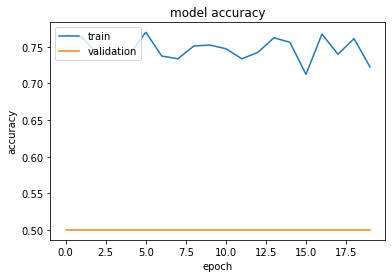

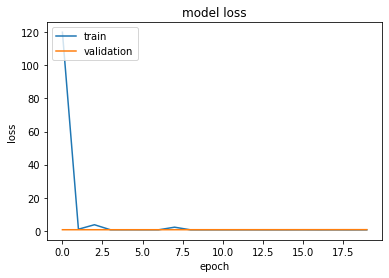

In [7]:
Train_CNN_Model(model)

Found 624 images belonging to 2 classes.


No handles with labels found to put in legend.



Confusion Matrix
 -------------------------
[[  0 234]
 [  0 390]]
Accuracy: 0.625000
Precision: 0.625000
Recall: 1.000000
F1 score: 0.769231
ROC AUC: 0.500000


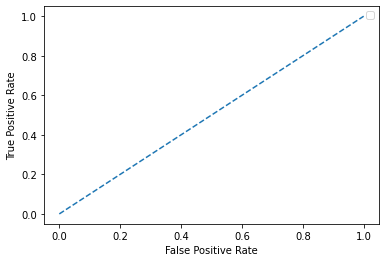

In [8]:
Evaluate_CNN_Model()